# Factor Research 

for FnGuide Application

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

from pprint import pprint as pp

In [2]:
import quantstats as qs

In [3]:
cwd = Path.cwd()
data_dir = cwd / "data"
fnguide_dir = data_dir / "fnguide"
kqdl_dir = data_dir / "kqdl"
navernews_dir = data_dir / "navernews" / "navernews"

## 1. Import Dataset

학교에서 추출한 DataGuide 파일들을 불러오기

추출할 때 기간 내 delisted 종목도 포함시켰기 때문에 survivorship bias 적음.

In [4]:
## 추출한 fnguide 데이터를 dataframe으로 전처리

def preprocess_dataguide_csv(fn_file_name, cols, skiprows=8):
    fn_df = pd.read_csv(fnguide_dir / fn_file_name, encoding="cp949", skiprows=skiprows, thousands=",")
    fn_df = fn_df.melt(id_vars=cols, var_name="date", value_name="value")

    return fn_df

In [5]:
fn_file_names = [
    'dataguide_kse+kosdaq_20140101-20231215_stc_pricevolume.CSV',
    'dataguide_kse+kosdaq_20140101-20231219_stc_mktcap.CSV',
    'dataguide_kse+kosdaq_20140101-20231219_foreigner.CSV',
]

In [6]:
## 날짜가 아닌 컬럼들

cols = ['Symbol', 'Symbol Name', 'Kind', 'Item', 'Item Name ', 'Frequency',]

In [7]:
pricevolume_df = preprocess_dataguide_csv(fn_file_names[0], cols)
mktcap_df = preprocess_dataguide_csv(fn_file_names[1], cols)
foreigner_df = preprocess_dataguide_csv(fn_file_names[2], cols)

In [8]:
pricevolume_df['Item Name '].unique()

array(['수익률(%)', '수정주가(원)', '수정저가(원)', '수정고가(원)', '수정시가(원)', '거래량(주)',
       '거래대금(원)'], dtype=object)

In [9]:
mktcap_df['Item Name '].unique()

array(['시가총액 (티커-상장예정주식수 미포함)(백만원)'], dtype=object)

In [10]:
foreigner_df['Item Name '].unique()

array(['외국인보유비중(티커)(%)'], dtype=object)

In [11]:
pricevolume_df.info() # 원래 값이 "10,000" 와 같이 comma seperated string number로 되어있었음. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92848805 entries, 0 to 92848804
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Symbol       object 
 1   Symbol Name  object 
 2   Kind         object 
 3   Item         object 
 4   Item Name    object 
 5   Frequency    object 
 6   date         object 
 7   value        float64
dtypes: float64(1), object(7)
memory usage: 5.5+ GB


PBR 자료는 못 뽑아왔으므로, 자체 라이브러리인 `kqdl`을 통해 추출한 PBR 정보를 사용

In [29]:
kqdl_pbr = pd.read_pickle(kqdl_dir / "kqdl_pbr_20140101_20220531.pkl")

In [31]:
kqdl_pbr.head()

ticker,000020,000030,000040,000050,000060,000070,000075,000080,000087,000100,...,405640,406760,408920,409570,412930,413600,413630,415580,418170,419270
date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.55,NaN,0.82,0.41,1.38,0.48,0.0,1.09,0.0,1.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.56,NaN,0.83,0.42,1.37,0.47,0.0,1.08,0.0,1.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,0.56,NaN,0.83,0.43,1.37,0.47,0.0,1.09,0.0,1.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,0.56,NaN,0.82,0.43,1.37,0.48,0.0,1.09,0.0,1.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,0.58,NaN,0.83,0.42,1.37,0.48,0.0,1.08,0.0,1.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Transform dataset

퀀트 분석을 위한 panel 형태로 변환

In [12]:
def get_panel_df(df, item_name):
    panel_df = df.loc[df['Item Name '] == item_name].copy()
    panel_df = panel_df.pivot(index='date', columns='Symbol', values='value')
    panel_df = panel_df.reset_index()
    
    return panel_df

In [13]:
def transform_panel(panel_df, remove_holidays=True, drop_sid_prefix=True):
    panel_df = panel_df.set_index('date', inplace=False)
    panel_df.sort_index(inplace=True)

    if drop_sid_prefix:
        panel_df.columns = [sid[1:] for sid in panel_df.columns]

    if remove_holidays:
        panel_df = panel_df.dropna(how='all', axis=0)
    
    return panel_df

In [14]:
return_2d = transform_panel(get_panel_df(pricevolume_df, '수익률(%)'))
tradingmoneyvolume_2d = transform_panel(get_panel_df(pricevolume_df, '거래대금(원)'))
mktcap_2d = transform_panel(get_panel_df(mktcap_df, '시가총액 (티커-상장예정주식수 미포함)(백만원)'))
foreigner_2d = transform_panel(get_panel_df(foreigner_df, '외국인보유비중(티커)(%)'))


In [15]:
return_2d.tail(10)

,000010,000020,000030,000040,000050,000060,000070,000080,000090,000100,...,950110,950130,950140,950160,950170,950180,950190,950200,950210,950220
date,,,,,,,,,,,,,,,,,,,,,
2023-12-01,NaN,-0.84,NaN,-0.20,-0.35,NaN,0.00,1.58,NaN,0.33,...,0.23,10.10,2.36,0.00,0.00,NaN,1.66,-1.34,-0.50,0.73
2023-12-04,NaN,-0.85,NaN,1.38,1.05,NaN,0.14,1.34,NaN,-0.98,...,0.57,-1.48,0.32,-1.02,-0.51,NaN,1.45,2.13,-1.32,5.12
2023-12-05,NaN,2.14,NaN,0.19,-0.57,NaN,0.00,0.22,NaN,3.94,...,-1.35,26.23,2.93,-0.91,-1.55,NaN,-0.18,0.95,-0.82,7.81
2023-12-06,NaN,0.52,NaN,-2.72,1.85,NaN,0.14,0.66,NaN,1.42,...,1.37,-6.62,-0.69,-1.15,-2.09,NaN,8.94,0.56,-0.10,-0.75
2023-12-07,NaN,3.23,NaN,-0.60,-1.02,NaN,-1.58,0.00,NaN,2.02,...,0.56,-0.54,-1.63,-0.12,-1.20,NaN,-3.12,0.93,-1.66,1.29
2023-12-08,NaN,-0.30,NaN,1.00,0.92,NaN,0.88,-0.22,NaN,0.46,...,-0.45,-4.57,2.36,0.00,1.08,NaN,-1.27,1.30,0.53,-0.40
2023-12-11,NaN,-0.10,NaN,-0.20,0.23,NaN,0.43,1.09,NaN,-0.61,...,-0.23,-5.26,4.54,1.17,0.40,NaN,5.58,-1.83,0.00,-1.56
2023-12-12,NaN,0.71,NaN,0.20,-0.91,NaN,-0.86,0.65,NaN,0.15,...,6.67,-1.11,-3.46,-0.92,0.80,NaN,-4.31,1.49,1.57,-1.59
2023-12-13,NaN,-1.31,NaN,-0.99,0.69,NaN,-1.02,0.00,NaN,-1.53,...,3.92,-6.03,-0.91,-0.47,-0.93,NaN,-0.68,-5.50,-1.03,-1.67


## 3. Universe Filtering 

현실적인 포트폴리오 백테스팅을 위해 유동성 상위 2000 종목으로만 구성된 유니버스를 구성

In [16]:
START_DATE = '2014-01-01'
END_DATE = '2022-05-31' # news dataset은 여기까지 있음. 

SUBUNIVERSE = 2000

In [17]:
tradingmoneyvolume_2d.index

Index(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07', '2014-01-08',
       '2014-01-09', '2014-01-10', '2014-01-13', '2014-01-14', '2014-01-15',
       ...
       '2023-12-01', '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07',
       '2023-12-08', '2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14'],
      dtype='object', name='date', length=2450)

In [18]:
liquidity_rank_2d = tradingmoneyvolume_2d.rank(axis=1, method='dense', ascending=False)
univ2000_2d = liquidity_rank_2d <= SUBUNIVERSE

In [19]:
univ2000_2d.tail()

,000010,000020,000030,000040,000050,000060,000070,000080,000090,000100,...,950110,950130,950140,950160,950170,950180,950190,950200,950210,950220
date,,,,,,,,,,,,,,,,,,,,,
2023-12-08,False,True,False,False,False,False,True,True,False,True,...,False,True,True,True,True,False,True,True,True,True
2023-12-11,False,True,False,False,False,False,True,True,False,True,...,False,True,True,True,False,False,True,True,True,True
2023-12-12,False,True,False,False,False,False,True,True,False,True,...,True,True,True,True,False,False,True,False,True,True
2023-12-13,False,True,False,False,False,False,True,True,False,True,...,True,True,True,True,False,False,True,True,True,True
2023-12-14,False,True,False,True,False,False,True,True,False,True,...,True,True,True,True,False,False,True,True,True,True


In [20]:
# 모든 데이터셋에 univ2000 mask 적용

return_2d = return_2d.loc[START_DATE:END_DATE][univ2000_2d]
tradingmoneyvolume_2d = tradingmoneyvolume_2d.loc[START_DATE:END_DATE][univ2000_2d]
mktcap_2d = mktcap_2d.loc[START_DATE:END_DATE][univ2000_2d]
foreigner_2d = foreigner_2d.loc[START_DATE:END_DATE][univ2000_2d]


In [32]:
pbr_2d = kqdl_pbr.loc[START_DATE:END_DATE][univ2000_2d]

In [21]:
return_2d = return_2d * 0.01 # % -> decimal

In [36]:
return_2d.dropna(axis=1, how='all', inplace=True)
tradingmoneyvolume_2d.dropna(axis=1, how='all', inplace=True)
mktcap_2d.dropna(axis=1, how='all', inplace=True)
foreigner_2d.dropna(axis=1, how='all', inplace=True)

In [37]:
pbr_2d.dropna(axis=1, how='all', inplace=True)

In [38]:
return_2d.shape

(2069, 2588)

In [39]:
pbr_2d.shape

(2069, 2547)

DataGuide에서 뽑은 데이터와 내가 KRX에서 가져온 데이터와 일부 유니버스 차이가 있다. 

In [41]:
fnguide_universe = set(return_2d.columns)
kqdl_universe = set(pbr_2d.columns)

In [44]:
len(fnguide_universe - kqdl_universe)

41

In [45]:
len(kqdl_universe - fnguide_universe)

0

In [46]:
fnguide_universe - kqdl_universe

{'067370',
 '084440',
 '148780',
 '198940',
 '210120',
 '221800',
 '232830',
 '246250',
 '303360',
 '393210',
 '900040',
 '900050',
 '900070',
 '900080',
 '900090',
 '900100',
 '900110',
 '900120',
 '900130',
 '900140',
 '900180',
 '900250',
 '900260',
 '900270',
 '900280',
 '900290',
 '900300',
 '900310',
 '900340',
 '950010',
 '950100',
 '950110',
 '950130',
 '950140',
 '950160',
 '950170',
 '950180',
 '950190',
 '950200',
 '950210',
 '950220'}

일부 정상 종목이 포함되지 않는 경우가 있었고, 9로 시작하는 코드들이 대부분 빠졌다. 

빠진 종목들 중 시가총액이 큰 종목이 있진 않다.

종목코드는 언젠가 변화할 수 있는 대상이므로, 제대로 된 분석에선 자체적인 security id 부여가 필요하다. 

관련 기사: 

거래소, 주권·ETN 종목코드 체계 개편... 알파벳 혼용해 중복 방지 (23/05/23)

https://news.mt.co.kr/mtview.php?no=2023052314210810155

In [23]:
# Make checkpoint

return_2d.to_pickle(fnguide_dir / 'return_2d.pkl')
tradingmoneyvolume_2d.to_pickle(fnguide_dir / 'tradingmoneyvolume_2d.pkl')
mktcap_2d.to_pickle(fnguide_dir / 'mktcap_2d.pkl')
foreigner_2d.to_pickle(fnguide_dir / 'foreigner_2d.pkl')

더 작은 kqdl universe 기준으로 맞춰 분석을 진행한다. 


In [48]:
return_2d = return_2d.loc[:, list(kqdl_universe)].copy()
tradingmoneyvolume_2d = tradingmoneyvolume_2d.loc[:, list(kqdl_universe)].copy()
mktcap_2d = mktcap_2d.loc[:, list(kqdl_universe)].copy()
foreigner_2d = foreigner_2d.loc[:, list(kqdl_universe)].copy()

In [49]:
return_2d.shape

(2069, 2547)

In [51]:
pbr_2d.shape

(2069, 2547)

## 4. Factor Portfolio 

Fama-French 3 Factor Portfolio를 만들어 벤치마크(=단순 시가총액 가중 포트폴리오=마켓팩터)와 수익률 비교

In [87]:
return_1dshift = return_2d.shift(-1)

시그널은 다음 날부터 사용할 수 있으므로, 백테스팅 할 때는 return에 1 day shift를 준다. 

이것을 수행하지 않을 시 forward looking (=look-ahead bias)이 되어 아예 잘못된 결과가 나온다. 

### A. Market factor

$$ R_m - R_f $$ 

`Rf`는 기준금리 series 데이터가 따로 필요하므로 일단 상수로 가정

이 경우 Sharpe 지수는 신뢰하기 어렵게 됨.

In [88]:
RISK_FREE = 0.04 / 252 # 1년 4% 수익률을 252일로 나눔

In [89]:
cap_weight = mktcap_2d.div(mktcap_2d.sum(axis=1), axis=0)
Rm = (return_1dshift - RISK_FREE).mul(cap_weight).sum(axis=1)

In [90]:
Rm.index = pd.to_datetime(Rm.index)

<Axes: title={'center': 'Market Factor Portfolio'}, xlabel='date'>

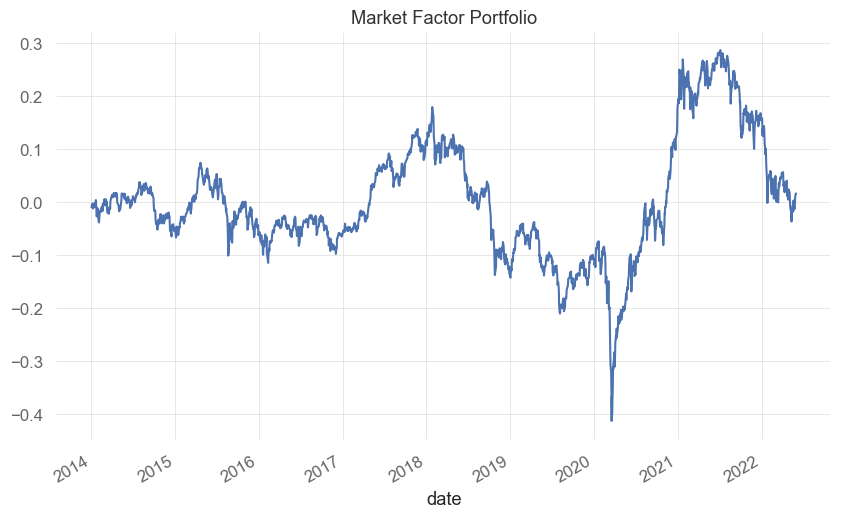

In [92]:
((1+Rm).cumprod()-1).plot(title='Market Factor Portfolio')

### B. HML

High Minus Low

$$
\text{HML} = \frac{1}{2} \left( (S_{\text{high}} + B_{\text{high}}) - (S_{\text{low}} + B_{\text{low}}) \right)
$$

In [52]:
small_2d = mktcap_2d.rank(axis=1, method='dense', ascending=False) >= mktcap_2d.shape[1] / 2
big_2d = mktcap_2d.rank(axis=1, method='dense', ascending=False) <= mktcap_2d.shape[1] / 2

high_2d = pbr_2d.rank(axis=1, method='dense', ascending=False) <= pbr_2d.shape[1] / 3
medium_2d = (pbr_2d.rank(axis=1, method='dense', ascending=False) > pbr_2d.shape[1] / 3) \
    & (pbr_2d.rank(axis=1, method='dense', ascending=False) <= pbr_2d.shape[1] * 2 / 3)
low_2d = pbr_2d.rank(axis=1, method='dense', ascending=False) > pbr_2d.shape[1] * 2 / 3

In [69]:
S_low = small_2d & low_2d
S_mid = small_2d & medium_2d
S_high = small_2d & high_2d

B_low = big_2d & low_2d
B_mid = big_2d & medium_2d
B_high = big_2d & high_2d

In [93]:
HML_portfolio = ((S_high | B_high) * return_1dshift - (S_low | B_low) * return_1dshift) * 1/2
HML = HML_portfolio.mean(axis=1)

In [100]:
HML_portfolio.index = pd.to_datetime(HML_portfolio.index)
HML.index = pd.to_datetime(HML.index)

<Axes: title={'center': 'Value Factor Portfolio'}, xlabel='date'>

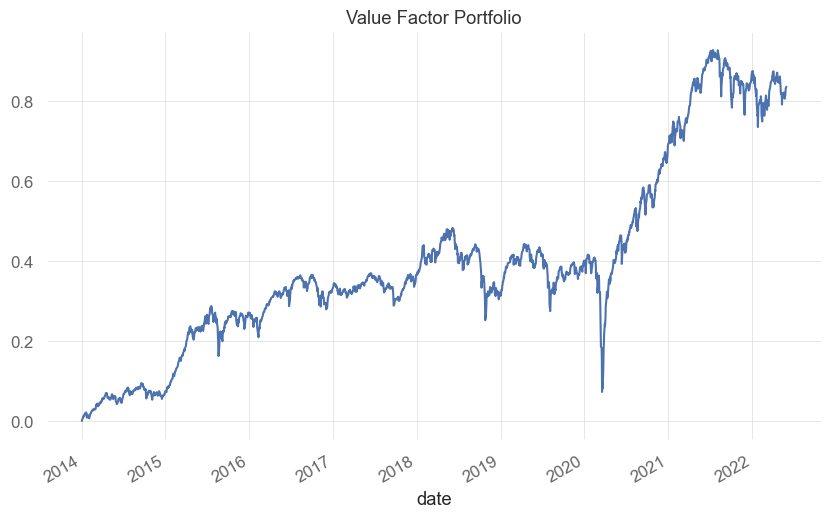

In [103]:
((1+HML).cumprod()-1).plot(title='Value Factor Portfolio')

### C. SMB

Small Minus Big

$$
\text{SMB} = \frac{1}{3} \left( (S_{\text{low}} + S_{\text{mid}} + S_{\text{high}}) - (B_{\text{low}} + B_{\text{mid}} + B_{\text{high}}) \right)

$$

In [95]:
SMB_portfolio = ((S_low | S_mid | S_high) * return_1dshift - (B_low | B_mid | B_high) * return_1dshift) * 1/3
SMB = SMB_portfolio.mean(axis=1)

In [101]:
SMB_portfolio.index = pd.to_datetime(SMB_portfolio.index)
SMB.index = pd.to_datetime(SMB.index)

<Axes: title={'center': 'Size Factor Portfolio'}, xlabel='date'>

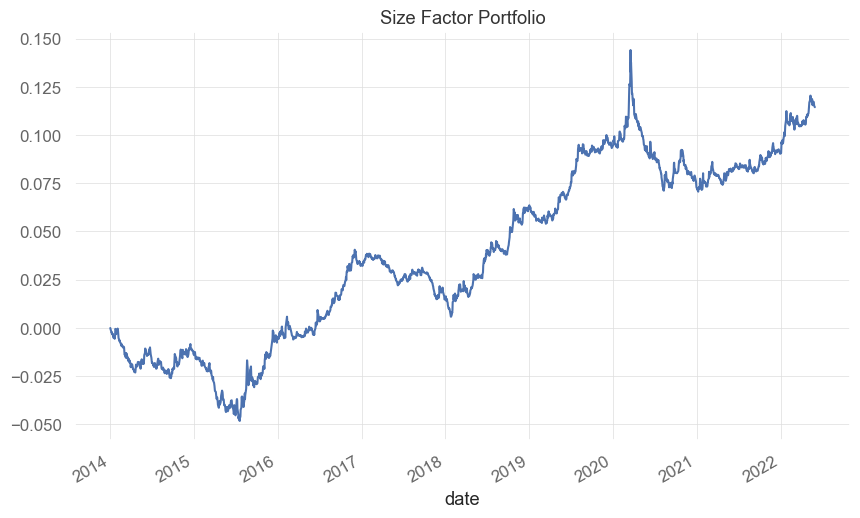

In [102]:
((1+SMB).cumprod()-1).plot(title='Size Factor Portfolio')

### 세 가지 팩터 종합

Text(0.5, 1.0, 'Factor Portfolios')

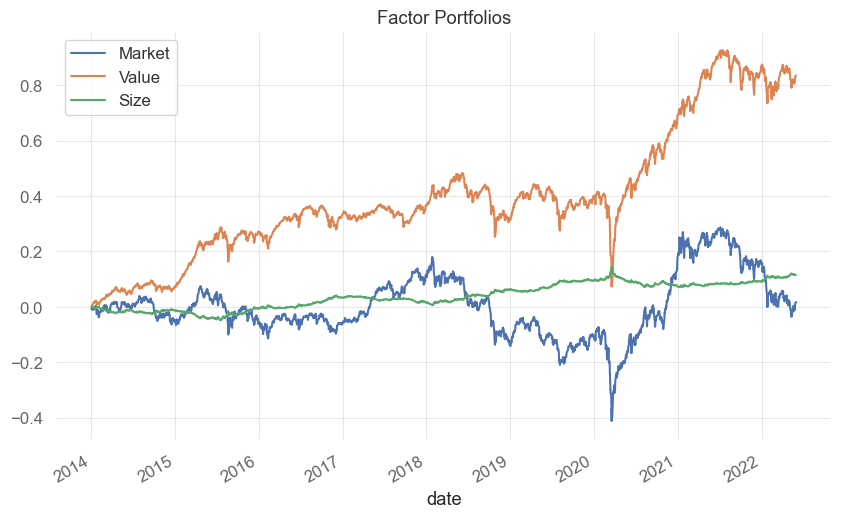

In [108]:
((1+Rm).cumprod()-1).plot(label='Market')
((1+HML).cumprod()-1).plot(label='Value')
((1+SMB).cumprod()-1).plot(label='Size')

plt.legend()
plt.title('Factor Portfolios')

## 5. Factor Portfolio 성과분석 상세

`quantstats` 이용

                           Strategy
-------------------------  ----------
Start Period               2014-01-02
End Period                 2022-05-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          11.44%
CAGR﹪                     0.89%

Sharpe                     0.64
Prob. Sharpe Ratio         96.73%
Smart Sharpe               0.61
Sortino                    1.0
Smart Sortino              0.94
Sortino/√2                 0.7
Smart Sortino/√2           0.67
Omega                      1.12

Max Drawdown               -6.42%
Longest DD Days            803
Volatility (ann.)          2.1%
Calmar                     0.14
Skew                       0.4
Kurtosis                   5.95

Expected Daily %           0.01%
Expected Monthly %         0.11%
Expected Yearly %          1.21%
Kelly Criterion            5.0%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.21%
Expected Shortfall (cVaR)  -0.21%

Max Consecutive Wins       9
Max C

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-19,2021-01-07,2022-05-30,803,-6.417499,-6.321572
2,2014-01-03,2015-07-20,2016-01-18,746,-4.820050,-4.580484
3,2016-12-05,2018-01-25,2018-07-17,590,-3.338523,-3.187171
4,2016-02-12,2016-03-09,2016-06-22,132,-1.176723,-1.158495
5,2019-01-03,2019-03-15,2019-05-07,125,-0.902233,-0.861124


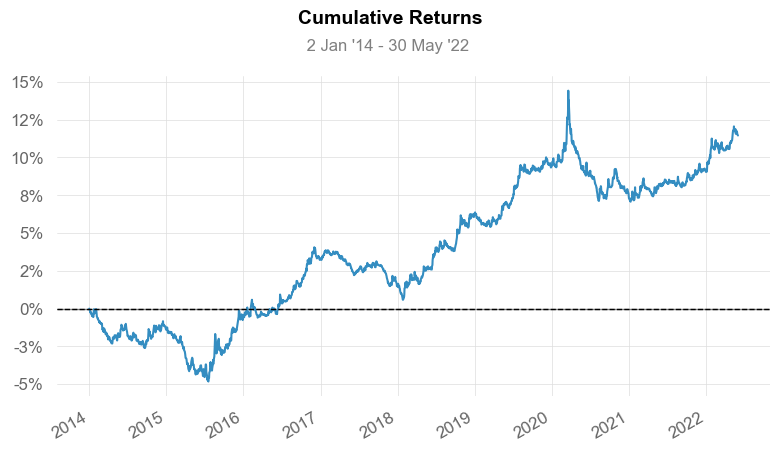

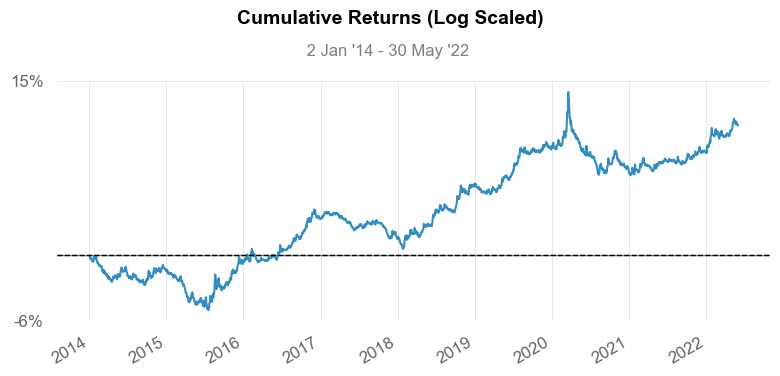

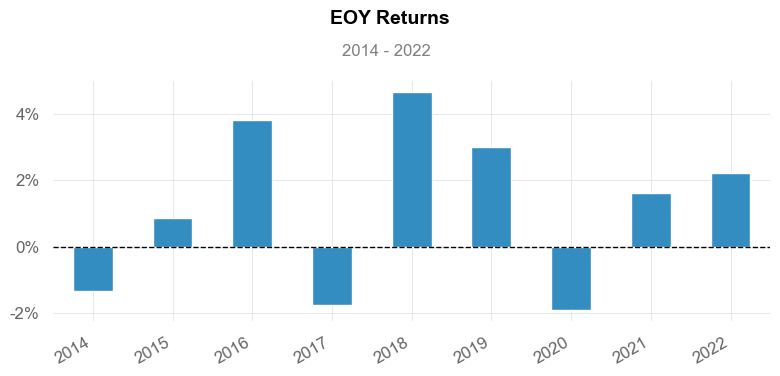

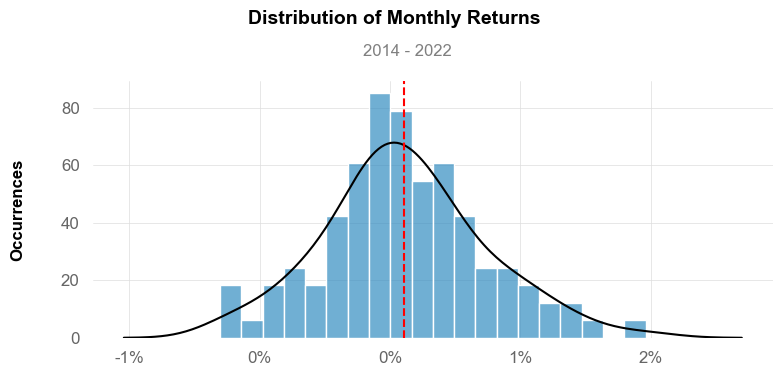

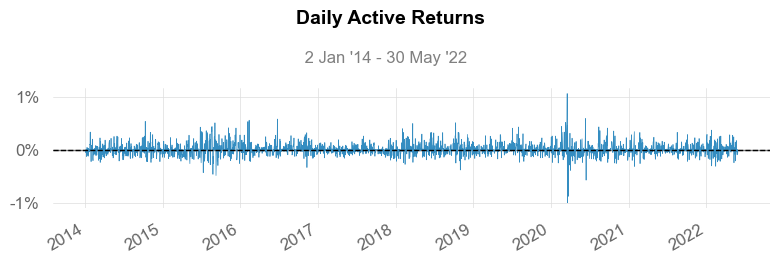

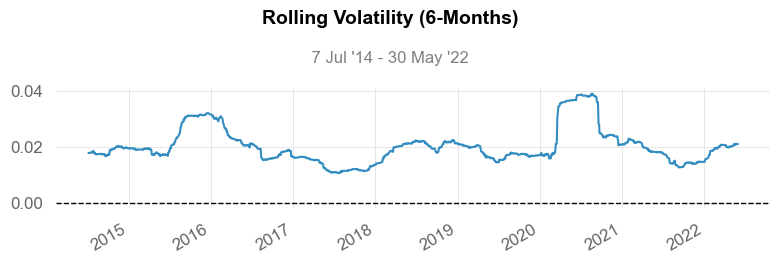

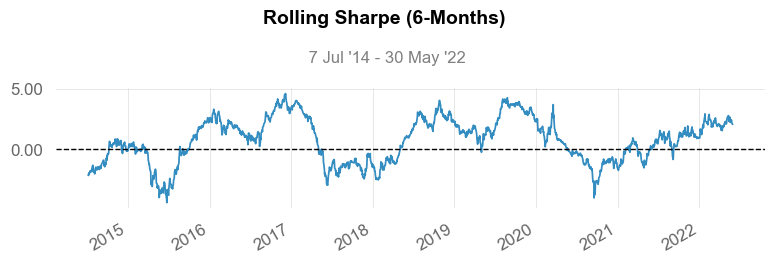

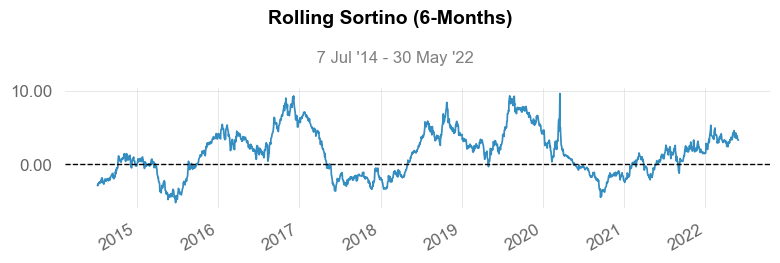

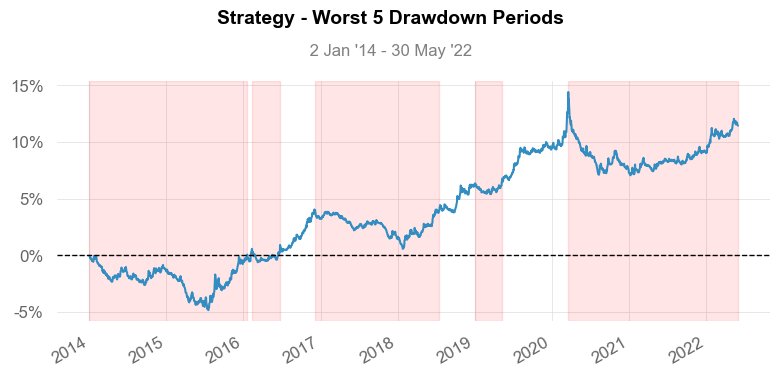

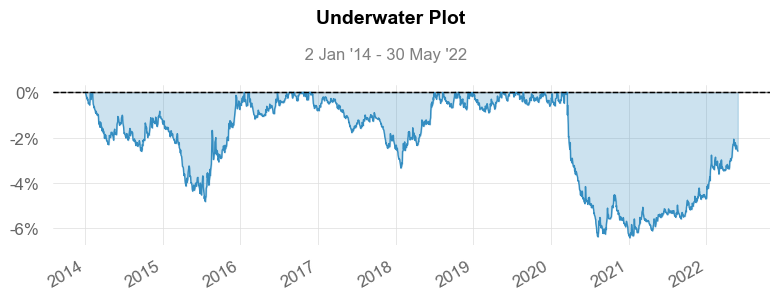

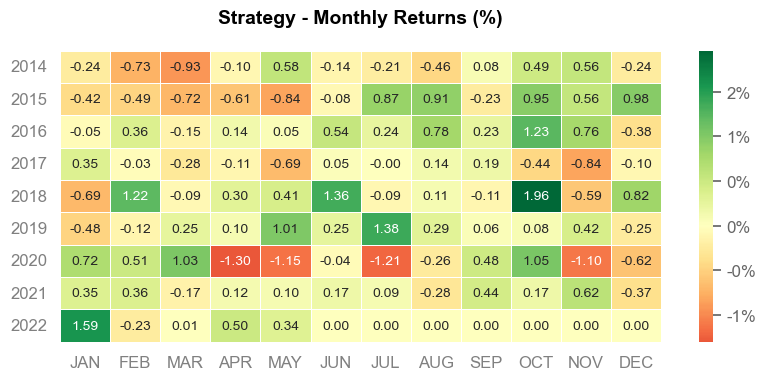

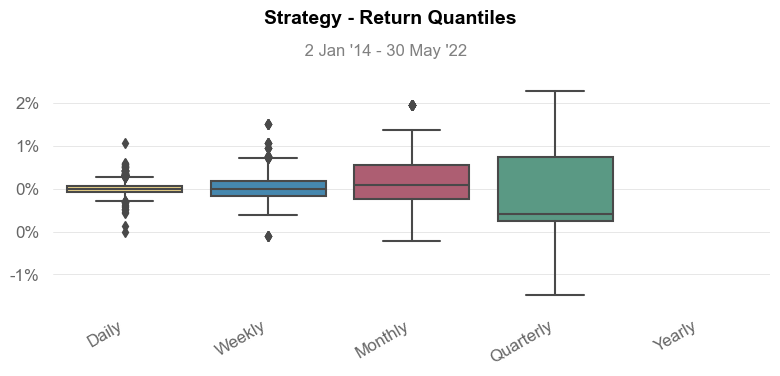

In [104]:
qs.reports.full(SMB)